# 沒有在過去12個月使用G@C的人 在環保重要性選擇題的答案分佈

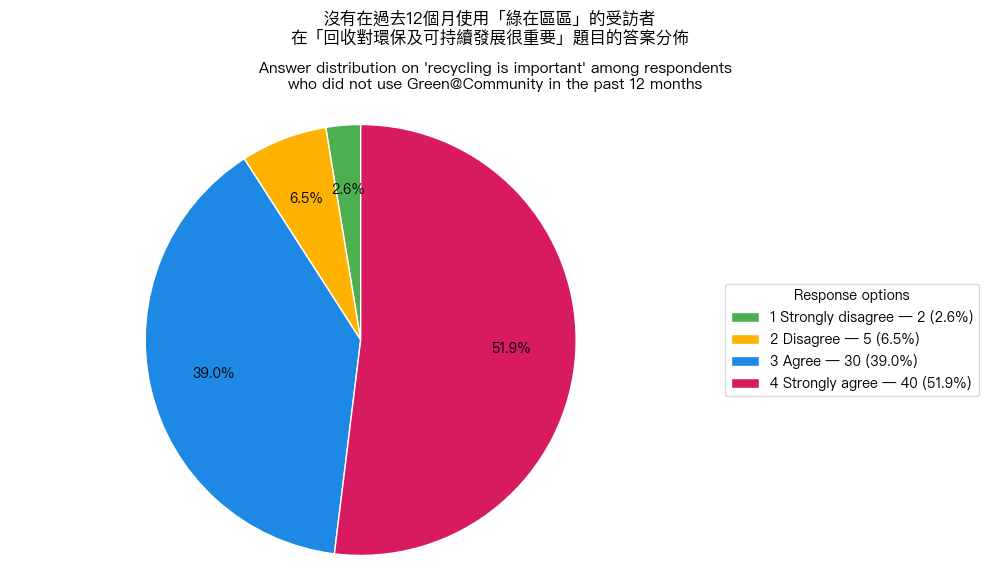

In [11]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- helper to find columns by header pattern ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

# column: 12-month use of G@C (Yes/No)
use_patterns = [
    r"in\s+the\s+past\s+12\s+months.*used\s+any\s+green@community\s+recycling\s+facility",
    r"在最近12個月.*有否使用過.*綠在區區.*回收設施",
]
use_col = find_col(df.columns, use_patterns)
if use_col is None:
    raise RuntimeError("Could not find the 'past 12 months use' Yes/No column.")

# column: Likert question on recycling importance
likert_patterns = [
    r"to\s+what\s+extent\s+do\s+you\s+agree.*recycling\s+is\s+important\s+for\s+environmental\s+protection\s+and\s+sustainable\s+development",
    r"你多大程度同意.*回收.*可持續發展.*重要",
]
likert_col = find_col(df.columns, likert_patterns)
if likert_col is None:
    raise RuntimeError("Could not find the recycling importance question column.")

use_series    = df[use_col].astype(str)
likert_series = df[likert_col]

# ---------- map Yes/No usage ----------
def used_facility(text: str):
    s = str(text).strip().lower()
    if s in {"yes", "y", "是", "有"}:
        return True
    if s in {"no", "n", "否", "沒有", "未有", "無"}:
        return False
    return None

use_flags = use_series.map(used_facility)

# respondents who did NOT use G@C in the past 12 months
mask_no = use_flags == False

# ---------- clean Likert responses ----------
def map_likert(val):
    s = str(val).strip()
    if s == "" or s.lower() == "nan":
        return None
    try:
        code = int(float(s))           # handles 1, 2, 3, 4 (or "3.0")
    except ValueError:
        m = re.match(r"(\d)", s)       # handles "3 Agree"
        if not m:
            return None
        code = int(m.group(1))
    return code if code in {1,2,3,4} else None

likert_clean = likert_series[mask_no].map(map_likert).dropna().astype(int)

# mapping numeric code -> labelled category
code_to_label = {
    1: "1 Strongly disagree",
    2: "2 Disagree",
    3: "3 Agree",
    4: "4 Strongly agree",
}
order_codes = [1, 2, 3, 4]

counts_raw = likert_clean.value_counts().to_dict()
labels = [code_to_label[c] for c in order_codes if c in counts_raw]
counts = [counts_raw[c] for c in order_codes if c in counts_raw]

total = sum(counts)
pct = [c / total * 100 if total > 0 else 0.0 for c in counts]
if total == 0:
    raise RuntimeError("No valid recycling-importance responses found for non-users of G@C.")

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        matplotlib.rcParams["font.family"] = font_name
        break
matplotlib.rcParams["axes.unicode_minus"] = False

# ---------- plot pie chart ----------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_facecolor("white")

colors = ["#4CAF50", "#FFB300", "#1E88E5", "#D81B60"][:len(labels)]

wedges, _texts, _autotexts = ax.pie(
    counts,
    labels=None,  # legend instead
    colors=colors,
    startangle=90,
    autopct=lambda p: f"{p:.1f}%" if total > 0 else "",
    pctdistance=0.7,
    wedgeprops=dict(edgecolor="white"),
)

legend_labels = [f"{lab} — {c} ({p:.1f}%)" for lab, c, p in zip(labels, counts, pct)]
ax.legend(
    wedges,
    legend_labels,
    title="Response options",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
)

# ---------- centred titles (with slight CN left offset) ----------
title_cn = "沒有在過去12個月使用「綠在區區」的受訪者\n在「回收對環保及可持續發展很重要」題目的答案分佈\n"
title_en = ("\nAnswer distribution on 'recycling is important' among respondents\n"
            "who did not use Green@Community in the past 12 months")

x_cn = 0.495  # small left nudge so CN visually aligns with EN; set to 0.5 if you want exact center
fig.text(x_cn, 0.97, title_cn, ha="center", va="top", fontsize=12)
fig.text(0.5,  0.91, title_en, ha="center", va="top", fontsize=11)

ax.axis("equal")
plt.tight_layout(rect=[0, 0, 1, 0.84])
plt.show()
